# Policy-value verification

This notebook demonstrates the PVV module for analysis of global results.

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\rlipkis\.julia\dev\adastress\examples\pvv`


In [2]:
using AdaStress
using BSON
using Flux
using Random
using Statistics

┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1423


In [3]:
AdaStress.clean()
@time AdaStress.enable()

 74.945088 seconds (28.72 M allocations: 1.763 GiB, 0.91% gc time, 8.79% compilation time)


┌ Info: Cleaned submodule environment.
└ @ AdaStress C:\Users\rlipkis\.julia\dev\AdaStress\src\utils.jl:175
┌ Info: Enabled submodule SoftActorCritic.
└ @ AdaStress C:\Users\rlipkis\.julia\dev\AdaStress\src\utils.jl:93
┌ Info: Enabled submodule PolicyValueVerification.
└ @ AdaStress C:\Users\rlipkis\.julia\dev\AdaStress\src\utils.jl:93


In [4]:
using AdaStress.PolicyValueVerification
using AdaStress.SoftActorCritic

## Load networks

In [5]:
BSON.@load "ac.bson" ac

In [6]:
network = PolicyValueVerification.mean_network(ac; act_mins=-3*ones(2), act_maxs=3*ones(2));

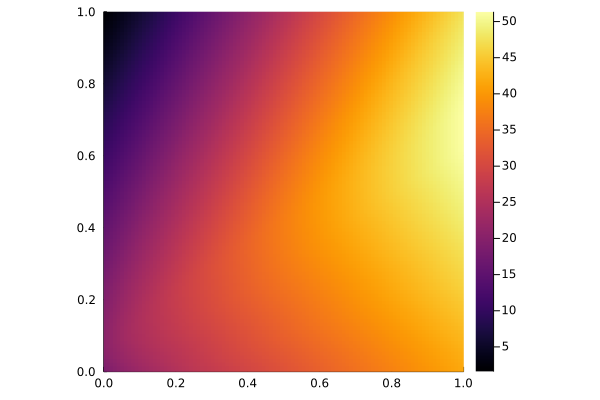

In [7]:
cs = CrossSection((x1, x2) -> (x1, x2, 0.0))
limits = ([0.0, 0.0], [1.0, 1.0])
nnet = cross_section(network, cs, limits)
p = PolicyValueVerification.visualize(nnet, limits)

## Single-process refinement

In [8]:
midpoint_value = PolicyValueVerification.compute_output(nnet, mean(limits))[] # arbitrarily selecting value at center
r = BinaryRefinery(network=nnet, val=midpoint_value, tol=1e-2)

BinaryRefinery(NeuralVerification.Network(NeuralVerification.Layer[NeuralVerification.Layer{NeuralVerification.ReLU, Float32}(Float32[1.0 0.0; 0.0 1.0; … ; 0.0663836 -0.22164291; 0.18726023 0.32180178], Float32[0.0, 0.0, 0.0, 0.06434134, 0.15910563, 0.06734634, 0.12795128, 0.02877767, 0.2674945, 0.08766379  …  0.01708374, 0.12863629, -0.0033181927, 0.0, 0.066982105, 0.29182646, 0.050594833, -0.015629852, 0.21764842, 0.12192547], NeuralVerification.ReLU()), NeuralVerification.Layer{NeuralVerification.ReLU, Float32}(Float32[1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … -0.013806255 0.0041335435; 0.0 0.0 … 0.31593278 -0.06720135], Float32[0.0, 0.0, 0.0, -0.003257088, 0.0786668, 0.018744063, 0.16234486, -0.005848254, 0.18668616, -0.037215162  …  0.12507787, -0.013195036, 0.16134949, 0.1047949, 0.012929194, 0.15064989, 0.02780743, -0.018758638, -0.014201627, -0.039242838], NeuralVerification.ReLU()), NeuralVerification.Layer{NeuralVerification.ReLU, Float32}(Float32[1.0 0.0 … 0.0 0.0;

In [9]:
tree = analyze(r, limits);

Cells awaiting processing: 0 	 Time: 0:00:17


Vol. proportion proven true  : 0.571044921875
Vol. proportion proven false : 0.405517578125
Vol. proportion unproven     : 0.0234375
Total size of spanning tree  : 271 leaves
Total size of tree in memory : 46.192 kB
Maximum depth of tree        : 7
Processor balancing score    : NaN


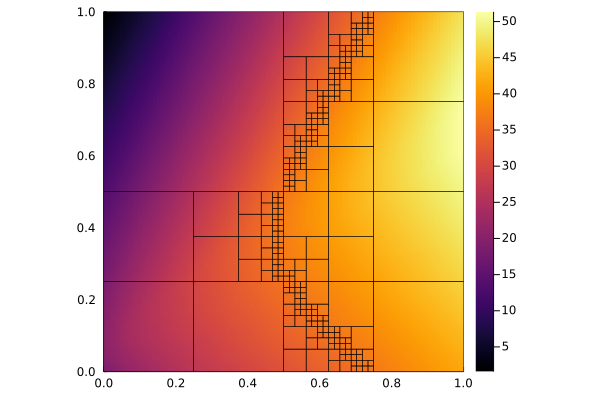

In [10]:
visualize(p, tree; tol=1e-3) # no coloring

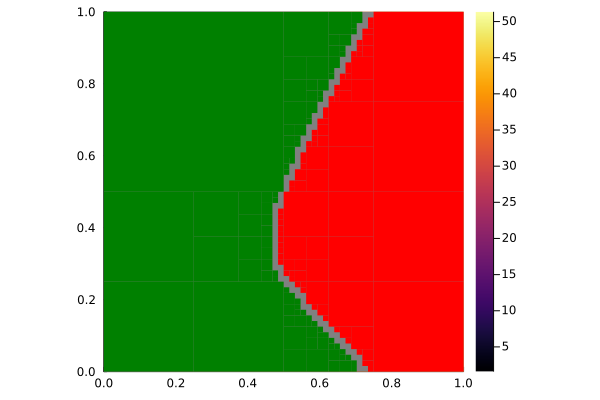

In [11]:
visualize(p, tree; fill=:proof, tol=1e-3) # coloring by proof status

## Multiprocess refinement

The analysis can be distributed over any number of cores, with the workload dynamically balanced across available processors. This is recommended in most cases, especially for high-dimensional and/or low-tolerance refinements.

Loading AdaStress on multiple processes requires careful invocation of Julia's distributed functionality, due to the non-atomicity of environment commands. See the example below for proper code loading.

In [12]:
using Distributed
addprocs(4)

4-element Vector{Int64}:
 2
 3
 4
 5

In [13]:
@everywhere using Pkg

In [14]:
foreach(i -> remotecall_fetch(Pkg.activate, i, Pkg.project().path), workers()) # should not be called with @everywhere

      From worker 2:	  Activating project at `C:\Users\rlipkis\.julia\dev\adastress\examples\pvv`
      From worker 3:	  Activating project at `C:\Users\rlipkis\.julia\dev\adastress\examples\pvv`
      From worker 4:	  Activating project at `C:\Users\rlipkis\.julia\dev\adastress\examples\pvv`
      From worker 5:	  Activating project at `C:\Users\rlipkis\.julia\dev\adastress\examples\pvv`


In [15]:
@everywhere using AdaStress

In [16]:
foreach(i -> remotecall_fetch(AdaStress.load, i), workers()) # should not be called with @everywhere

      From worker 2:	[ Info: Loaded submodule SoftActorCritic.
      From worker 2:	[ Info: Loaded submodule PolicyValueVerification.
      From worker 3:	[ Info: Loaded submodule SoftActorCritic.
      From worker 3:	[ Info: Loaded submodule PolicyValueVerification.
      From worker 4:	[ Info: Loaded submodule SoftActorCritic.
      From worker 4:	[ Info: Loaded submodule PolicyValueVerification.
      From worker 5:	[ Info: Loaded submodule SoftActorCritic.
      From worker 5:	[ Info: Loaded submodule PolicyValueVerification.


In [17]:
@everywhere using AdaStress.PolicyValueVerification

In [18]:
midpoint_value = PolicyValueVerification.compute_output(nnet, mean(limits))[]
r = BinaryRefinery(network=nnet, val=midpoint_value, tol=1e-2, ks=[3, 6]);

In [19]:
tree_mp = analyze(r, limits);

Cells awaiting processing: 0 	 Time: 0:00:159m


Vol. proportion proven true  : 0.571044921875
Vol. proportion proven false : 0.405517578125
Vol. proportion unproven     : 0.0234375
Total size of spanning tree  : 271 leaves
Total size of tree in memory : 46.192 kB
Maximum depth of tree        : 7
Processor balancing score    : 0.8165493015948844


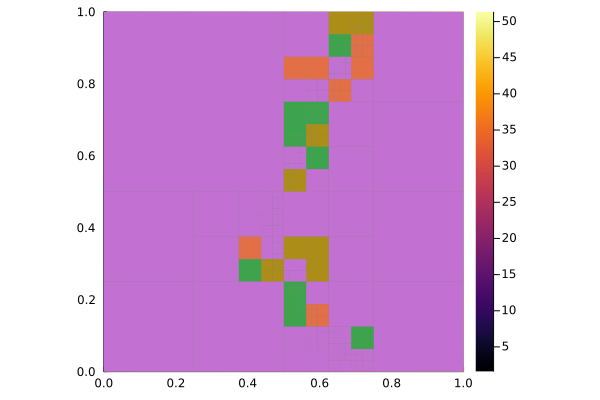

In [20]:
visualize(p, tree_mp; fill=:pid, tol=1e-3) # coloring by process id